Load the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/WebMining2/"

Mounted at /content/drive
 BX-Book-Ratings.csv	    Preprocessed_data.csv
 BX_Books.csv		    PreProcessing.ipynb
 BX-Users.csv		    Prepro_UserItemBased.ipynb
'Copy of WebMining.ipynb'  'RecommenderSystem_on_Steam_data(balanced).ipynb'
 PrePro_Alg.ipynb	    WebMining.ipynb


In [3]:
%cd /content/drive/MyDrive/WebMining2

/content/drive/MyDrive/WebMining2


In [4]:
books = pd.read_csv('BX_Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']
users.columns = ['userID', 'Location', 'Age']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df = pd.read_csv('Preprocessed_data.csv', index_col=0, encoding = 'ISO-8859-1')

Inspecting the dataset

In [6]:
df.user_id.nunique()

92107

Print total rows of books and unique rows

In [7]:
print('Total rows: ', len(df))
print('Unique rows based on ISBN: ', len(df.isbn.unique()))
print('Unique rows based on ISBN: ', len(df.drop_duplicates(['isbn', 'book_title'])))
df.head(5)

Total rows:  1031175
Unique rows based on ISBN:  270170
Unique rows based on ISBN:  270170


,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


In [8]:
print(df.shape)
print(list(df.columns))

(1031175, 18)
['user_id', 'location', 'age', 'isbn', 'rating', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city', 'state', 'country']


In [9]:
print('Unique rows based on ISBN: ', len(df.drop_duplicates(['isbn'])))
print('Unique rows based on userID: ', len(df.drop_duplicates(['user_id'])))

Unique rows based on ISBN:  270170
Unique rows based on userID:  92107


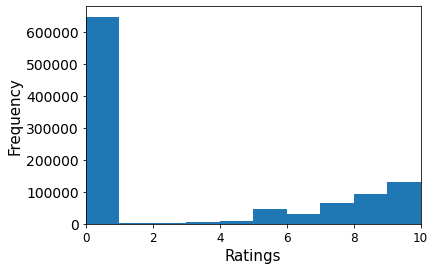

In [10]:
df['rating'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=14)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,10.0])
plt.show()

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df['rating'].describe())
r_counts = df['rating'].value_counts()
print(r_counts)

count   1031175.000
mean          2.839
std           3.854
min           0.000
25%           0.000
50%           0.000
75%           7.000
max          10.000
Name: rating, dtype: float64
0     647323
8      91806
10     71227
7      66404
9      60780
5      45355
6      31689
4       7617
3       5118
2       2375
1       1481
Name: rating, dtype: int64


**PreProcessing**

In [12]:
def print_information(df, name):
    df_num_ratings =  df.shape[0]
    df_num_users = len(df['user_id'].unique())
    df_num_books = len(df['isbn'].unique())
    print(f'For {name}:\n\tNumber of unique users: {df_num_users}\n\tNumber of unique books: {df_num_books}\n\tNumber of ratings: {df_num_ratings}')

In [13]:
print_information(df, 'original data frame')

For original data frame:
	Number of unique users: 92107
	Number of unique books: 270170
	Number of ratings: 1031175


Generate artificial Book ID

In [14]:
#Trim ISBN, as they have an extra space in the end
df['isbn'] = df['isbn'].str.strip()
df['user_id'] = pd.to_numeric(df.user_id, downcast='integer')
#generate artificial Book_ID
df['book_id'] = np.arange(len(df))

In [15]:
df.head()

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country,book_id
0,2,"stockton, california, usa",18.000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.000,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa,0
1,8,"timmins, ontario, canada",34.744,0002005018,5,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada,1
2,11400,"ottawa, ontario, canada",49.000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada,2
3,11676,"n/a, n/a, n/a",34.744,0002005018,8,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN,3
4,41385,"sudbury, ontario, canada",34.744,0002005018,0,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada,4


Discard all implicit ratings equal to 0

In [16]:
#only taking rating between 1 and 10
df_no_zeros = df.loc[df['rating'] > 0]
print_information(df_no_zeros, 'dataframe only books rated with 1 or higher (i.e. no 0 ratings)')
df_no_zeros['rating'].value_counts().sort_values()

For dataframe only books rated with 1 or higher (i.e. no 0 ratings):
	Number of unique users: 68092
	Number of unique books: 149842
	Number of ratings: 383852


1      1481
2      2375
3      5118
4      7617
6     31689
5     45355
9     60780
7     66404
10    71227
8     91806
Name: rating, dtype: int64

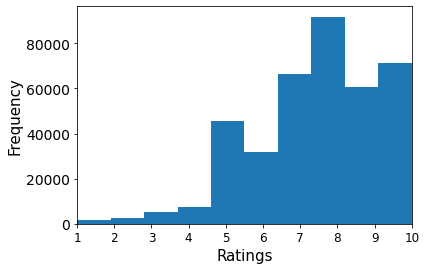

In [17]:
df_no_zeros['rating'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=14)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([1,10])
plt.show()

Books rated more than 20 times

In [18]:
#only taking ratings where users rated at least 20 times
df_10_ratings_least = df_no_zeros.groupby('user_id').filter(lambda df: df.shape[0] > 19)
print_information(df_10_ratings_least, 'dataframe only users who rated more than 20 times')

For dataframe only users who rated more than 20 times:
	Number of unique users: 3305
	Number of unique books: 108385
	Number of ratings: 217735


DROP unnecessary Colums

In [19]:
columns = ['age', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'city']
ratings_f = df_10_ratings_least.drop(columns, axis=1)
ratings_f.head()

,user_id,location,isbn,rating,book_title,book_author,Summary,Language,Category,state,country,book_id
3,11676,"n/a, n/a, n/a",0002005018,8,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,3
8,116866,"ottawa, ,",0002005018,9,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],",",NaN,8
13,219008,"halifax, nova scotia, canada",0002005018,7,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],nova scotia,canada,13
14,263325,"fredericton, new brunswick, canada",0002005018,6,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],new brunswick,canada,14
19,35704,"kansas city, missouri, usa",0374157065,6,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,"Describes the great flu epidemic of 1918, an o...",en,['Medical'],missouri,usa,19


In [20]:
# List the movieId after the ratings count filtering
# Preserve 100.00% of the original books in ratings dataframe
# But after filtering, preserve only  82.13% of the users
books_list_rating = ratings_f.book_id.unique().tolist()
books_filter = ratings_f[ratings_f.book_id.isin(books_list_rating)]
print('Preserved rate of the books : {0:.2f} %'.format(len(ratings_f.book_id.unique())/len(books_filter.book_id.unique()) * 100))
print('Preserved rate of the users : {0:.2f} %'.format(len(ratings_f.user_id.unique())/len(df.user_id.unique()) * 100))

# Discard books which became not rated by anybody 
books_filter = ratings_f[ratings_f.book_id.isin(books_list_rating)]
print('Preserved rate of the books : {0:.2f} %'.format(len(ratings_f.book_id.unique())/len(df.book_id.unique()) * 100))
print('Preserved rate of the users : {0:.2f} %'.format(len(ratings_f.user_id.unique())/len(df.user_id.unique()) * 100))

Preserved rate of the books : 100.00 %
Preserved rate of the users : 3.59 %
Preserved rate of the books : 21.12 %
Preserved rate of the users : 3.59 %


In [21]:
# Map book to id:
Mapping_file = dict(zip(books_filter.book_title.tolist(), books_filter.book_id.tolist()))

UserBased

User-Item Matrix

In [22]:
columns = ['location', 'isbn', 'book_title', 'book_author', 'Summary', 'Language', 'Category', 'state', 'country']
ratings_f1 = ratings_f.drop(columns, axis=1)
ratings_f1.head()

,user_id,rating,book_id
3,11676,8,3
8,116866,9,8
13,219008,7,13
14,263325,6,14
19,35704,6,19


In [23]:
ratings_f1

,user_id,rating,book_id
3,11676,8,3
8,116866,9,8
13,219008,7,13
14,263325,6,14
19,35704,6,19
...,...,...,...
1031015,278418,5,1031015
1031048,278418,3,1031048
1031137,278633,9,1031137
1031141,278633,7,1031141


In [24]:
ratings_f1 = pd.merge(books_filter[['book_id']], ratings_f1, on="book_id", how="right")
ratings_f1.head(5)

,book_id,user_id,rating
0,3,11676,8
1,8,116866,9
2,13,219008,7
3,14,263325,6
4,19,35704,6


In [25]:
#Sort on user, item
ratings_f1 = ratings_f1.sort_values(by=['user_id','book_id'])

In [26]:
def create_pivot_table(pd_df):
    data = pd_df.values
    #print(data.shape)
    rows, row_pos = np.unique(data[:, 1], return_inverse=True)
    cols, col_pos = np.unique(data[:, 0], return_inverse=True)
    pivot_matrix = np.zeros((len(rows), len(cols)), dtype=data.dtype)
    pivot_matrix[row_pos, col_pos] = data[:, 2]
    print(pivot_matrix.shape)
    return pivot_matrix

In [27]:
ratings_f2 = create_pivot_table(ratings_f1)

(3305, 217735)


**Similarity Matrix for User and item**

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(ratings_f2.T, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

#user_correlation = cosine_similarity(ratings_f2.T)
#user_correlation[np.isnan(user_correlation)] = 0

#user_correlation = np.array(age_similarity)

print('Shape of User Similarity Matrix:', user_correlation.shape)
# Item Similarity Matrix
#item_correlation = 1 - pairwise_distances(ratings_f2, metric='cosine')
#item_correlation[np.isnan(item_correlation)] = 0
#print('Shape of Item Similarity Matrix:', item_correlation.shape)

**Predict rating based on item-based or user-based methods**

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        #pred = 0 + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        mean_item_rating = ratings.mean(axis=0)
        ratings_diff = (ratings - mean_item_rating[np.newaxis, :])
        #pred = 0 + ratings_diff.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred = mean_item_rating[np.newaxis, :] + ratings_diff.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    elif type == 'content':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred.clip(min=0)

In [ ]:
user_prediction = predict(ratings_f2.T, user_correlation, type='user')
item_prediction = predict(ratings_f2.T, item_correlation, type='item'

**Recommend Books**

In [ ]:
user_pred_df = pd.DataFrame(user_prediction, columns = list(book_filter.book_id))
item_pred_df = pd.DataFrame(item_prediction, columns = list(books_filter.book_id))

In [ ]:
def recommend_books(pred_df, userID, books, original_ratings, num_recommendations, method_name):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = pred_df.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the books information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(books, how = 'left', left_on = 'book_id', right_on = 'book_id').
                     sort_values(['book_rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating book that the user hasn't seen yet.
    recommendations = (books[~books['book_id'].isin(user_full['book_id'])].
         merge(pd.DataFrame(sorted_user_predictions).rename_axis('book_id').reset_index(), how = 'left',
               left_on = 'book_id',
               right_on = 'book_id').
         rename(columns = {user_row_number: method_name}).
         sort_values(method_name, ascending = False).
                       iloc[:num_recommendations, :]
                      )

    return user_full, recommendations